```
# 60.19/20
9f0fb6690089f72de7866333baeacd357580eddf  ../../data/shehui/shehui_phones_loglik.csv
9db096ce25c6f40c852a4fd467d0af2dec36598c  ../../data/shehui/shehui_feats.csv
```

In [19]:
phones_df_path = "../../data/shehui/shehui_phones_loglik.csv"
feats_df_path = "../../data/shehui/shehui_feats.csv"
acfeats_path = "../../data/shehui/shehui_acoustics_shift_10ms.csv"  # acoustic features from Praat
annot_path = "../../data/shehui/shehui_judge.csv"  # manual annotation
!sha1sum $phones_df_path $feats_df_path $acfeats_path $annot_path

9f0fb6690089f72de7866333baeacd357580eddf  ../../data/shehui/shehui_phones_loglik.csv
9db096ce25c6f40c852a4fd467d0af2dec36598c  ../../data/shehui/shehui_feats.csv
5c6dbb7aa1b66fd76a56e122720f099f48e75a5a  ../../data/shehui/shehui_acoustics_shift_10ms.csv
7338ee4755f5853be3cd6a3ce7711553485e84fc  ../../data/shehui/shehui_judge.csv


## Load Data

In [20]:
import pandas as pd
WORD = "社會"
phones_df = pd.read_csv(phones_df_path)
fafeats_df = pd.read_csv(feats_df_path)
acfeats_df = pd.read_csv(acfeats_path)
annot_df = pd.read_csv(annot_path, header=None, names=["utt_id", "annot"])
annot_df.annot.fillna("ʂ", inplace=True)
annot_df.annot = annot_df.annot.str.replace("d", "s")

In [21]:
acfeats_df.head()

,file,times,cog,sd,sk,kt
0,ZWH_GY_1203,0,1422.999784,1987.264706,1.356341,1.109356
1,ZWH_GY_1203,1,2361.731875,2372.780208,0.638981,-0.356338
2,ZWH_GY_1203,2,3383.371160,2269.120446,-0.196466,-0.569342
3,ZWH_GY_1203,3,4049.714782,2147.545847,-0.379987,0.403159
4,ZWH_GY_1203,4,4592.580562,1814.476466,-0.880846,2.331999


In [22]:
print(acfeats_df.groupby("file").count().times.head())
print(fafeats_df.groupby("utt_id").count().t.head())

file
CJH_GY_1544    37
CJH_GY_2944    35
CJJ_GY_3607    67
CJJ_GY_3612    34
CJJ_GY_3628    25
Name: times, dtype: int64
utt_id
CJH_GY_1544    35
CJH_GY_2944    30
CJJ_GY_3607    62
CJJ_GY_3612    28
CJJ_GY_3628    19
Name: t, dtype: int64


In [23]:
annot_df.head()

,utt_id,annot
0,CJH_GY_1544,ʂ
1,CJH_GY_2944,ʂ
2,CJJ_GY_3607,ʂ
3,CJJ_GY_3612,ʂ
4,CJJ_GY_3628,ʂ


In [24]:
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

fa_merged = []
for utt_id, utt_df in tqdm(fafeats_df.groupby("utt_id")):
  onset_phone = utt_df.phone.iloc[0]
  ph_utt_df = phones_df.query(f"utt_id=='{utt_id}'")
  ph_utt_df = ph_utt_df.loc[ph_utt_df.phone==onset_phone, :]
  fa_utt_df = utt_df.loc[utt_df.phone==onset_phone, :]
  annot_phone = annot_df.query(f"utt_id=='{utt_id}'").annot.iloc[0]
  assert ph_utt_df.shape[0] == fa_utt_df.shape[0]

  ac_utt_df = acfeats_df.query(f"file=='{utt_id}'")
  fa_utt_df = fa_utt_df.assign(
                cog=ac_utt_df.iloc[:fa_utt_df.shape[0], :].cog.values,
                annot_phone=annot_phone,
                retroLL=ph_utt_df.loc[:,"ʂ"],
                dentalLL=ph_utt_df.loc[:,"s"],
                dentalLLR=ph_utt_df.loc[:,"s"]-ph_utt_df.loc[:,"ʂ"])
  fa_merged.append(fa_utt_df)
fa_merged_df = pd.concat(fa_merged)

  0%|          | 0/101 [00:00<?, ?it/s]

In [25]:
fa_merged_df.shape

(1202, 49)

In [26]:
fa_merged_df.head()

,utt_id,t,phone,ml_phone,0,1,2,3,4,5,...,35,36,37,38,39,cog,annot_phone,retroLL,dentalLL,dentalLLR
2030,CJH_GY_1544,0,s,x,2.368972,-0.000552,0.082727,2.312782,0.137186,0.454745,...,-0.538467,0.504833,-0.905498,-1.037818,1.708621,1523.473758,ʂ,-5.021909,-3.336164,1.685745
2031,CJH_GY_1544,1,s,io,3.251752,-0.110333,-3.105189,2.239906,0.369762,0.238583,...,-1.079678,0.511085,-0.267823,-0.747937,-0.169399,3256.293592,ʂ,-5.255044,-2.783185,2.471859
2032,CJH_GY_1544,2,s,io,3.860597,-0.261525,-0.829215,2.180478,0.925222,0.075655,...,-0.258980,1.086715,1.122740,-0.299623,-1.130589,4032.376099,ʂ,-5.871971,-3.923607,1.948364
2033,CJH_GY_1544,3,s,io,3.876378,-0.757896,0.805240,1.839582,1.938820,-0.009636,...,0.787746,0.700332,0.042494,0.145141,-2.800359,4328.858134,ʂ,-4.132582,-2.614569,1.518013
2034,CJH_GY_1544,4,s,s,3.938467,-0.839008,0.230716,2.156287,0.057243,-0.155147,...,0.741284,-1.891332,-0.185319,0.128766,-1.940095,4244.724536,ʂ,-3.969868,-1.430866,2.539001


In [27]:
fa_merged_df.columns.get_loc("0")

4

In [28]:
from sklearnex.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


tsne = TSNE()
feat0_idx = fa_merged_df.columns.get_loc("0")
proj_feat = tsne.fit_transform(fa_merged_df.iloc[:, feat0_idx:feat0_idx+40])

/home/seantyh/miniconda3/envs/mfa/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


In [29]:
fa_merged_df

,utt_id,t,phone,ml_phone,0,1,2,3,4,5,...,35,36,37,38,39,cog,annot_phone,retroLL,dentalLL,dentalLLR
2030,CJH_GY_1544,0,s,x,2.368972,-0.000552,0.082727,2.312782,0.137186,0.454745,...,-0.538467,0.504833,-0.905498,-1.037818,1.708621,1523.473758,ʂ,-5.021909,-3.336164,1.685745
2031,CJH_GY_1544,1,s,io,3.251752,-0.110333,-3.105189,2.239906,0.369762,0.238583,...,-1.079678,0.511085,-0.267823,-0.747937,-0.169399,3256.293592,ʂ,-5.255044,-2.783185,2.471859
2032,CJH_GY_1544,2,s,io,3.860597,-0.261525,-0.829215,2.180478,0.925222,0.075655,...,-0.258980,1.086715,1.122740,-0.299623,-1.130589,4032.376099,ʂ,-5.871971,-3.923607,1.948364
2033,CJH_GY_1544,3,s,io,3.876378,-0.757896,0.805240,1.839582,1.938820,-0.009636,...,0.787746,0.700332,0.042494,0.145141,-2.800359,4328.858134,ʂ,-4.132582,-2.614569,1.518013
2034,CJH_GY_1544,4,s,s,3.938467,-0.839008,0.230716,2.156287,0.057243,-0.155147,...,0.741284,-1.891332,-0.185319,0.128766,-1.940095,4244.724536,ʂ,-3.969868,-1.430866,2.539001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,ZWH_GY_5146,6,s,s,6.271282,0.288601,1.624487,3.004203,0.384152,-0.509716,...,0.662172,0.100784,-0.167566,0.771863,-0.258160,6869.196734,ʂ,-5.726554,-0.100608,5.625946
1167,ZWH_GY_5146,7,s,ɕ,5.156349,0.505198,0.046733,2.899183,0.329735,-0.441903,...,1.091654,-1.482600,0.103139,0.967701,-1.015686,6384.197005,ʂ,-7.370776,-0.755591,6.615185
1168,ZWH_GY_5146,8,s,ɕ,3.297651,0.750196,0.863829,3.154321,0.376913,-0.033612,...,1.766673,-1.411282,1.143020,0.733513,-2.354564,6088.662542,ʂ,-10.491932,-4.656101,5.835831
1169,ZWH_GY_5146,9,s,ɕ,1.593383,1.016605,4.437990,2.867140,0.216997,0.215802,...,1.493291,-0.761203,-1.613871,0.761939,-2.560383,5153.520612,ʂ,-6.399535,-4.281276,2.118259


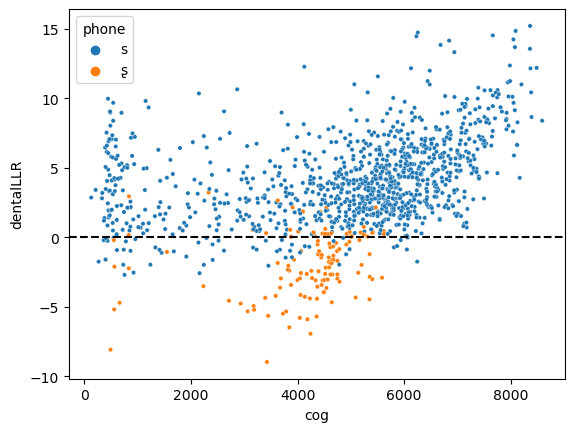

In [30]:
sns.scatterplot(x="cog", y="dentalLLR", 
                hue="phone",
                data=fa_merged_df, s=10)
plt.axhline(0, color="k", linestyle="--")

<Axes: xlabel='cog', ylabel='dentalLLR'>

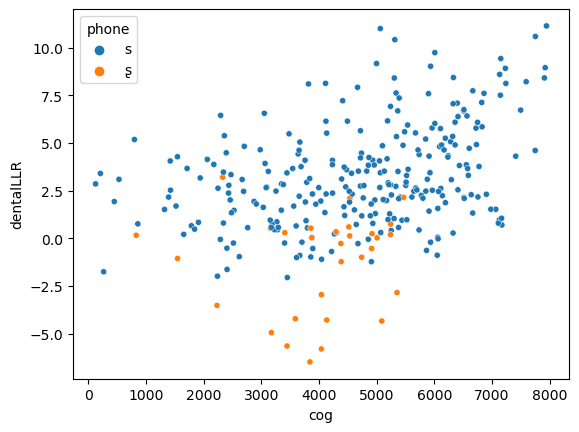

In [31]:
sns.scatterplot(x="cog", y="dentalLLR", 
                hue="phone",
                data=fa_merged_df.query("t<3"), s=20)

<Axes: xlabel='cog', ylabel='dentalLLR'>

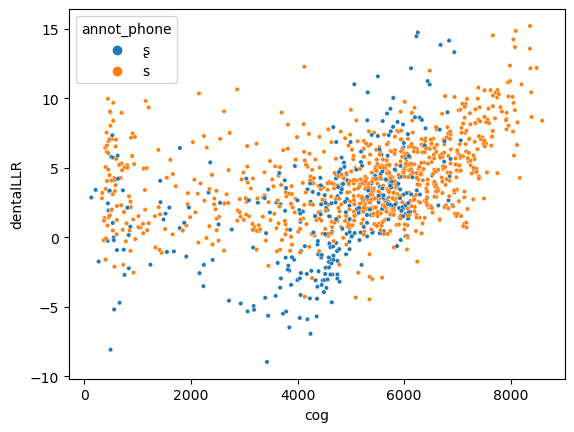

In [32]:
sns.scatterplot(x="cog", y="dentalLLR", 
                hue="annot_phone",
                data=fa_merged_df, s=10)